<center> <h1>  Peer-graded Assignment: The best classifier </h1> </center>


This notebook will complete the final project peer-graded assignment for the Coursera cousre Machine Learning with Python. It predicts whether a loan case will be paid off or not.

Specifically, the notebook will load a historical dataset from previous loan applications, clean the data, train and evaluate different classification algorithm on the data. The following algorithms will be used to train the prediction models:

- k-Nearest Neighbour

- Decision Tree

- Support Vector Machine

- Logistic Regression

After the training, models will be tested on a test dataset. The accuracy of each classifier will be calcuated using the following metrics when these are applicable:

- Jaccard index

- F1-score

- LogLoass



In [50]:
import sys
sys.path.append('/Users/chjp007/opt/miniconda3/lib/python3.7/site-packages')
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn import metrics

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [51]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

### Load Data From CSV File


In [52]:
df = pd.read_csv('loan_train.csv')

### Convert to date time object


In [53]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])

# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [54]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


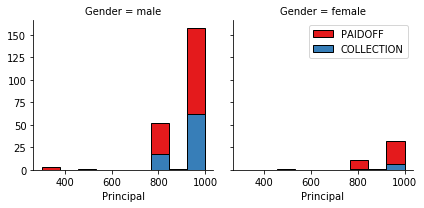

In [55]:

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

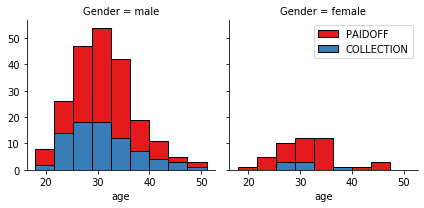

In [56]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


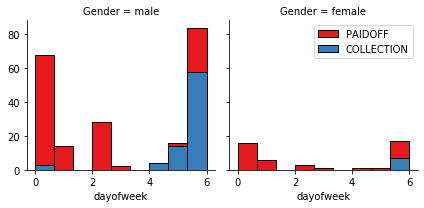

In [57]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [58]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [59]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [60]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [61]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [62]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [63]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

### Feature Selection


Let's define feature sets, X:


In [64]:
X = Feature

What are our lables?


In [65]:
y = df['loan_status'].values

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [66]:
X= preprocessing.StandardScaler().fit(X).transform(X)

# Classification


Now, I will use the training set to build an accurate model. Then use the test set to report the accuracy of the model
I will use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [67]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [68]:
from sklearn.neighbors import KNeighborsClassifier

Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.64285714, 0.58571429, 0.72857143, 0.7       , 0.75714286,
       0.68571429, 0.8       , 0.74285714, 0.72857143, 0.68571429,
       0.7       , 0.71428571, 0.68571429, 0.68571429, 0.7       ,
       0.71428571, 0.71428571, 0.72857143, 0.71428571])

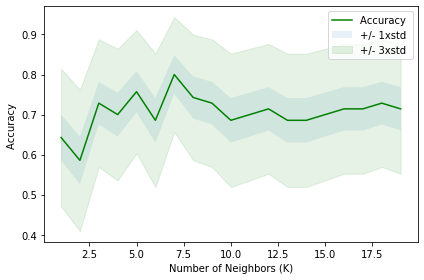

In [69]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [70]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8 with k= 7


### Use the k with best accuracy to train the KNN model
k = 7 gives the best accuracy for the KNN model, so a model bestK is trained and will be used later on the test data set

In [71]:
bestK = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)

# Decision Tree


In [72]:
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
loanTree.fit(X_train,y_train)
predTree = loanTree.predict(X_test)
print (predTree[0:5])
print (y_test[0:5])


['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [73]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.7


In [74]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

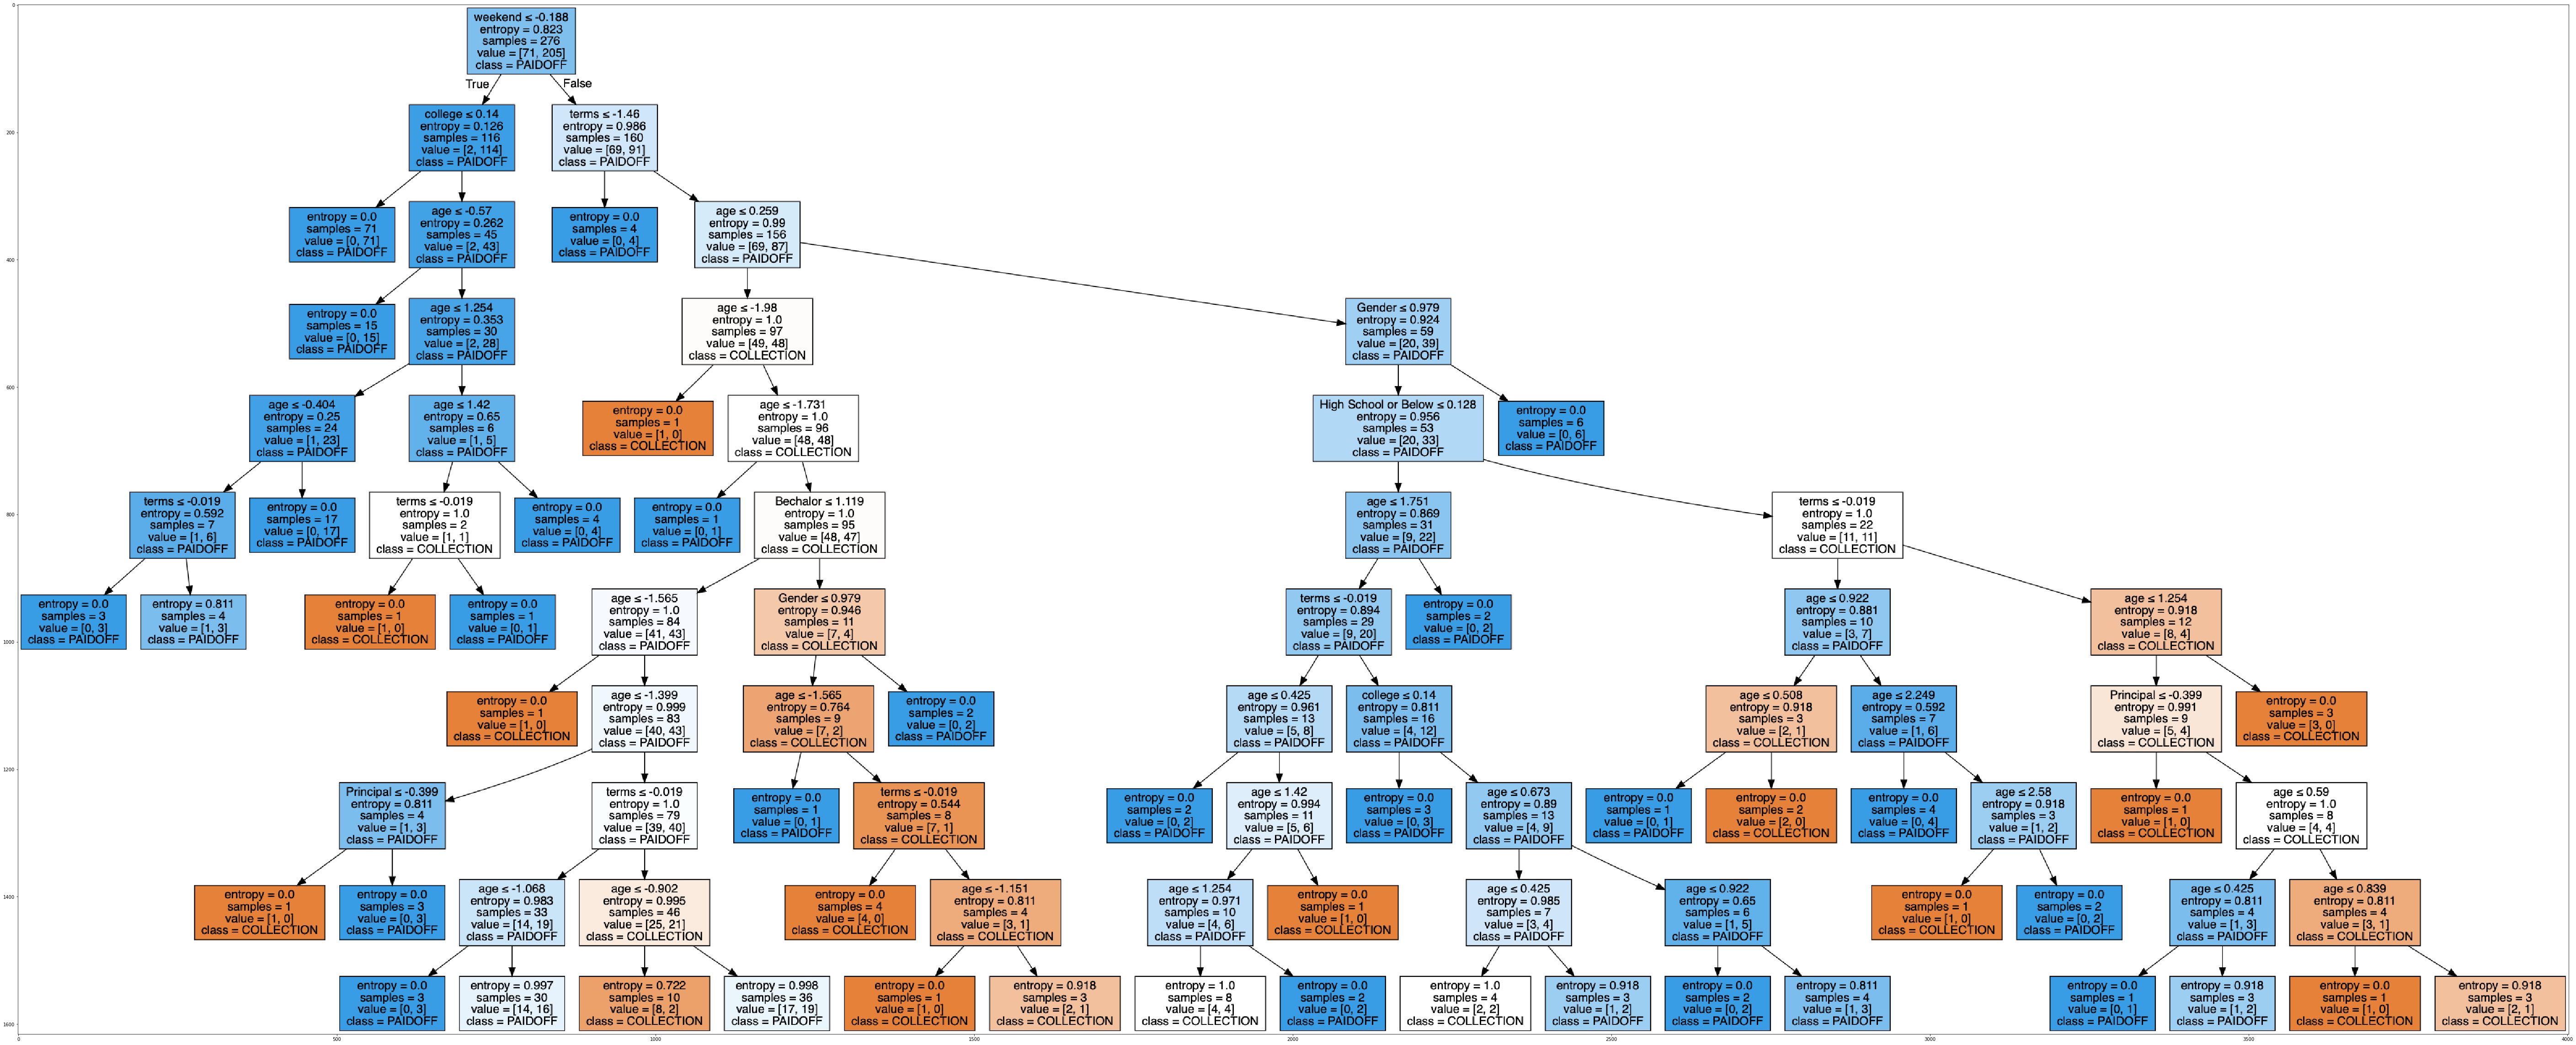

In [75]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = Feature.columns
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [76]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [77]:
yhat = clf.predict(X_test)

In [78]:
print("SVM's Accuracy: ", metrics.accuracy_score(y_test, yhat) )

SVM's Accuracy:  0.7428571428571429


# Logistic Regression


In [79]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

In [80]:
print("Logistic Regression's Accuracy: ", metrics.accuracy_score(y_test, yhat) )

Logistic Regression's Accuracy:  0.6857142857142857


# Model Evaluation using Test dataset loan_test.csv


In [81]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [82]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

clean, preprocess and normalize the test set

In [83]:
test_df = pd.read_csv('loan_test.csv')
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature, pd.get_dummies(test_df['education']) ], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X = Feature
X= preprocessing.StandardScaler().fit(X).transform(X)
y = test_df['loan_status'].values

build dataframe modelMetrics to keep model evaluation results

In [84]:
modelMetrics = pd.DataFrame(columns=['Algorithm','Jaccard','F1-score','LogLoss'])

## evaluate KNN algorithm

In [85]:
yhat=bestK.predict(X)

In [86]:
modelMetrics.loc[1] = ['KNN', jaccard_score(y, yhat,pos_label='COLLECTION'), f1_score(y, yhat, average='micro'), 'NA']

## evaluate Decision tree

In [87]:
yhat = loanTree.predict(X)
modelMetrics.loc[2] = ['Decision Tree', jaccard_score(y, yhat,pos_label='COLLECTION'), f1_score(y, yhat, average='micro'), 'NA']

## evaluate SVM

In [88]:
yhat = clf.predict(X)
modelMetrics.loc[3] = ['SVM', jaccard_score(y, yhat,pos_label='COLLECTION'), f1_score(y, yhat, average='micro'), 'NA']

## evaluate LogisticRegression

In [89]:

yhat = LR.predict(X)
yhat_prob = LR.predict_proba(X)
modelMetrics.loc[4] = ['LogisticRegression', 
                       jaccard_score(y, yhat,pos_label='COLLECTION'), 
                       f1_score(y, yhat, average='micro'), 
                       log_loss(y, yhat_prob) ]

# Final Report of model accurarcy

The below table report the accuracy of the built model using different evaluation metrics:


In [90]:
modelMetrics

,Algorithm,Jaccard,F1-score,LogLoss
1,KNN,0.142857,0.666667,NA
2,Decision Tree,0.263158,0.740741,NA
3,SVM,0.266667,0.796296,NA
4,LogisticRegression,0.066667,0.740741,0.567215
